### COVID-19 Classification

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [0]:
from google.colab import drive
drive.mount("./gdrive")
!unzip "./gdrive/My Drive/Colab Notebooks/Copy of Assignment 5 Dataset.zip"

### Load chest x-ray dataset

In [0]:
data_dir = '/content/Assignment 5 Dataset'

In [5]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
validation_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


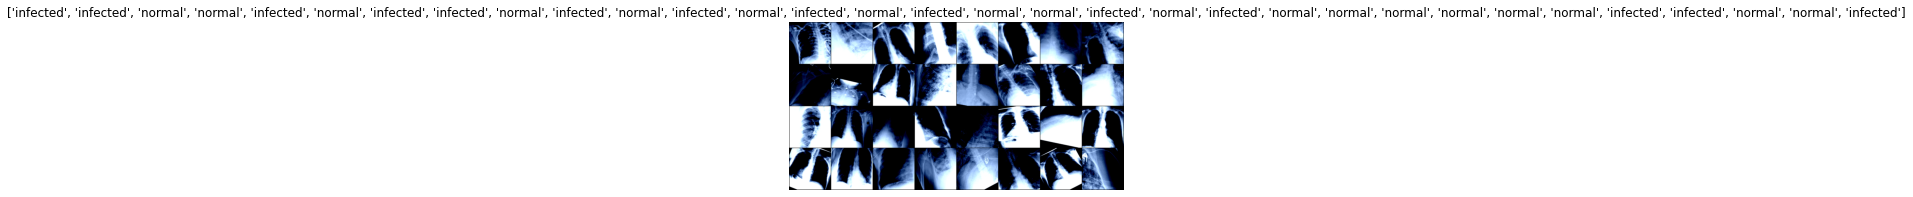

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

### Load pre-trained VGG-16

In [13]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [14]:
print(vgg16.classifier[3])

Linear(in_features=4096, out_features=4096, bias=True)


In [15]:
'''
  Freeze convolutional layers
'''
for param in vgg16.features.parameters():
    param.requires_grad = False

'''
  Replace FC layers with two FC layers
'''
features= []
features.extend([nn.Linear(25088, 130), nn.ReLU(inplace=True), nn.Dropout()])
features.extend([nn.Linear(130, len(class_names))])
vgg16.classifier = nn.Sequential(*features)

print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Load pretrained RESNET18

In [0]:
resnet18 = models.resnet18(pretrained=True)

In [17]:
'''
  Freeze convolutional layers
'''
for param in resnet18.parameters():
    param.requires_grad = False

'''
  Replace FC layers with two FC layers
'''
features= []
features.extend([nn.Linear(512, 130)])
features.extend([nn.Linear(130, len(class_names))])

resnet18.fc = nn.Sequential(*features)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Loss and accuracy

In [0]:
from sklearn.metrics import confusion_matrix
def compute_loss_and_accuracy(loader, model):
  correct = 0
  total = 0
  loss = 0
  correct_labels = []
  predicted_labels = []
  with torch.no_grad():
      for data in loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          correct_labels.extend(labels.tolist())
          predicted_labels.extend(predicted.tolist())

          loss += criterion(outputs, labels).item()

  accuracy = (100 * correct / total)
  conf_matrix = confusion_matrix(correct_labels, predicted_labels)
  return loss, accuracy, conf_matrix

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Training function

In [0]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def train_model(model, Epochs, criterion, optimizer, output_file):
    #if you have gpu then you need to convert the network and data to cuda
    #the easiest way is to first check for device and then convert network and data to device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.train()

    loss_per_iter_train = []
    accuracy_per_iter_train = []

    loss_per_iter_validation = []
    accuracy_per_iter_validation = []

    epochs = range(Epochs)
    for epoch in epochs:  # loop over the dataset multiple times

        running_loss = 0.0
        pbar = tqdm(enumerate(trainloader))

        correct = 0
        total = 0
        for i, data in pbar:
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
            # because PyTorch accumulates the gradients on subsequent backward passes. 
            # This is convenient while training RNNs. 
            # So, the default action is to accumulate the gradients on every loss.backward() call

            # forward + backward + optimize
            outputs = model(inputs)               #----> forward pass
            loss = criterion(outputs, labels)   #----> compute loss
            loss.backward()                     #----> backward pass
            optimizer.step()                    #----> weights update

            # print statistics
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_description(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, i * len(inputs), len(trainloader.dataset),
                    100. * i / len(trainloader),
                    loss.item()))
            
        loss_per_iter_train.append(running_loss)
        accuracy = (correct / total)*100
        accuracy_per_iter_train.append(accuracy)

        print('Train accuracy: {} %'.format(accuracy))

        validation_loss, validation_accuracy, conf_matrix = compute_loss_and_accuracy(validationloader, model)
        loss_per_iter_validation.append(validation_loss)
        accuracy_per_iter_validation.append(validation_accuracy)

        print('Validation accuracy: {} %'.format(validation_accuracy))
            
    plt.plot(epochs, loss_per_iter_validation, label="Loss per iteration validation")
    plt.show()

    plt.plot(epochs, accuracy_per_iter_validation, label="Accuracy per iteration validation")
    plt.show()

    plt.plot(epochs, loss_per_iter_train, label="Loss per iteration train")
    plt.show()

    plt.plot(epochs, accuracy_per_iter_train, label="Accuracy per iteration train")
    plt.show()

    train_loss, train_accuracy, conf_matrix = compute_loss_and_accuracy(trainloader, model)
    print('Train confusion matrix: ')
    print(conf_matrix)

    validation_loss, validation_accuracy, conf_matrix = compute_loss_and_accuracy(validationloader, model)
    print('Validation confusion matrix: ')
    print(conf_matrix)

    torch.save(model.state_dict(), output_file)
    print('Finished Training')

## Task 1

### Training VGG16


Train accuracy: 86.65833333333333 %
Validation accuracy: 86.93333333333334 %



Train accuracy: 86.74166666666666 %
Validation accuracy: 87.2 %



Train accuracy: 86.775 %
Validation accuracy: 86.53333333333333 %


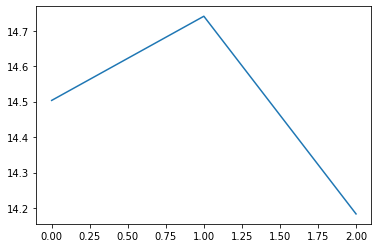

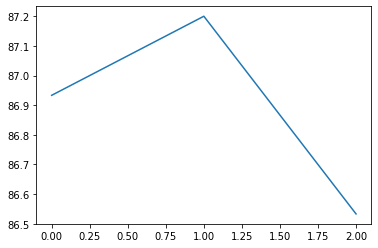

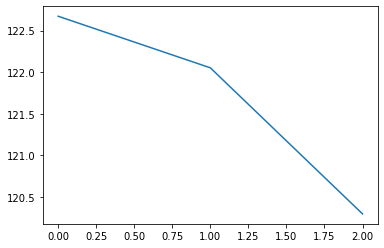

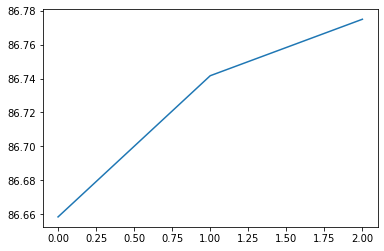

Train confusion matrix: 
[[3914 1005]
 [ 521 6560]]
Validation confusion matrix: 
[[495 120]
 [ 72 813]]
Finished Training


In [19]:
output_file='vgg16_FC_Only.pth'
Epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
train_model(vgg16, Epochs, criterion, optimizer, output_file)

In [20]:
loss, accuracy, conf_matrix = compute_loss_and_accuracy(testloader, vgg16)
print('Test Loss {}'.format(loss))
print('Test Accuracy {}'.format(accuracy))
print('Test Confusion Matrix')
print(conf_matrix)

Test Loss 9.03415958583355
Test Accuracy 93.8
Test Confusion Matrix
[[540  75]
 [ 18 867]]


In [0]:
!cp "/content/vgg16_FC_Only.pth" "./gdrive/My Drive/Colab Notebooks/vgg16_FC_Only.pth"

### Training Resnet


Train accuracy: 80.31666666666666 %
Validation accuracy: 81.8 %



Train accuracy: 83.63333333333334 %
Validation accuracy: 83.73333333333333 %



Train accuracy: 84.51666666666667 %
Validation accuracy: 83.2 %


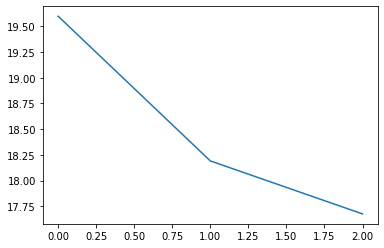

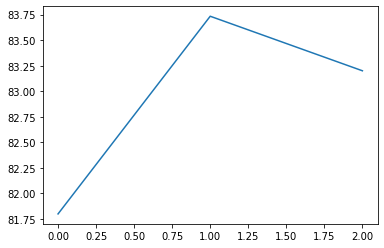

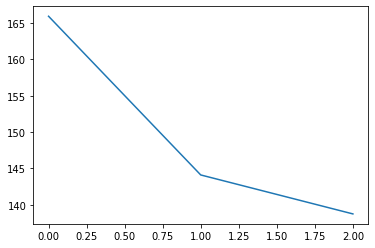

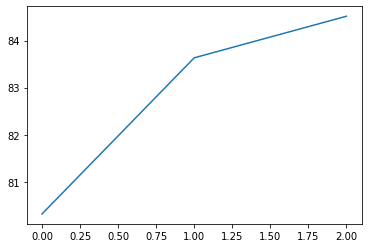

Train confusion matrix: 
[[3709 1210]
 [ 583 6498]]
Validation confusion matrix: 
[[482 133]
 [ 92 793]]
Finished Training


In [22]:
output_file='res18_FC_Only.pth'
Epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
train_model(resnet18, Epochs, criterion, optimizer, output_file)


In [23]:
loss, accuracy, conf_matrix = compute_loss_and_accuracy(testloader, vgg16)
print('Test Loss {}'.format(loss))
print('Test Accuracy {}'.format(accuracy))
print('Test Confusion Matrix')
print(conf_matrix)

Test Loss 8.782772716134787
Test Accuracy 93.06666666666666
Test Confusion Matrix
[[534  81]
 [ 23 862]]


In [0]:
!cp "/content/res18_FC_Only.pth" "./gdrive/My Drive/Colab Notebooks/res18_FC_Only.pth"

### Task 2

### VGG


Train accuracy: 83.19166666666666 %
Validation accuracy: 86.66666666666667 %



Train accuracy: 87.05833333333334 %
Validation accuracy: 87.6 %



Train accuracy: 87.9 %
Validation accuracy: 88.46666666666667 %


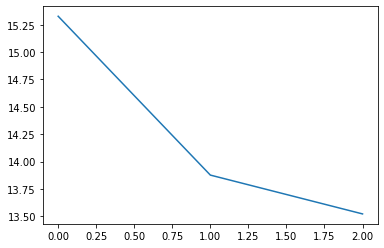

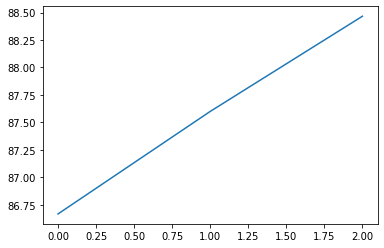

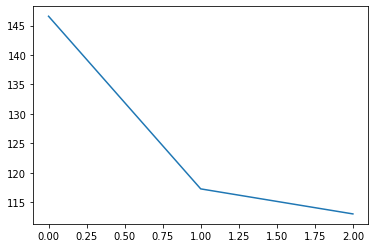

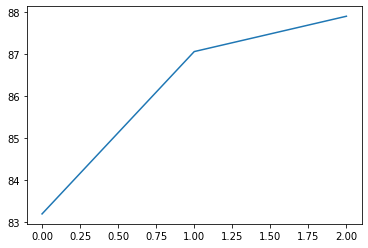

Train confusion matrix: 
[[4111  808]
 [ 493 6588]]
Validation confusion matrix: 
[[537  78]
 [ 89 796]]
Finished Training
Test Loss 7.944544967263937
Test Accuracy 94.4
Test Confusion Matrix
[[560  55]
 [ 29 856]]


In [93]:
vgg16_task2_1 = models.vgg16(pretrained=True)

'''
  Freeze all conv layers except the last convolutional layer
'''
for param in vgg16_task2_1.features[:28].parameters():
    param.requires_grad = False

'''
  Replace FC layers with two FC layers
'''
features= []
features.extend([nn.Linear(25088, 130), nn.ReLU(inplace=True), nn.Dropout()])
features.extend([nn.Linear(130, len(class_names))])
vgg16_task2_1.classifier = nn.Sequential(*features)

output_file='vgg16task2_1.pth'

Epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16_task2_1.parameters(), lr=0.001, momentum=0.9)
train_model(vgg16_task2_1, Epochs, criterion, optimizer, output_file)

loss, accuracy, conf_matrix = compute_loss_and_accuracy(testloader, vgg16_task2_1)
print('Test Loss {}'.format(loss))
print('Test Accuracy {}'.format(accuracy))
print('Test Confusion Matrix')
print(conf_matrix)


Train accuracy: 85.63333333333333 %
Validation accuracy: 89.93333333333334 %



Train accuracy: 90.4 %
Validation accuracy: 87.8 %



Train accuracy: 91.175 %
Validation accuracy: 90.93333333333334 %


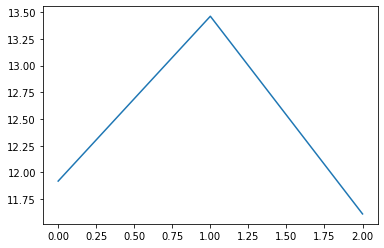

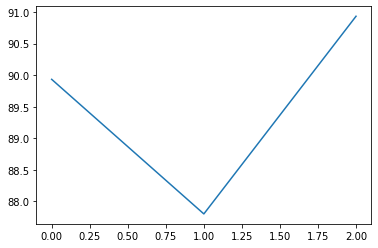

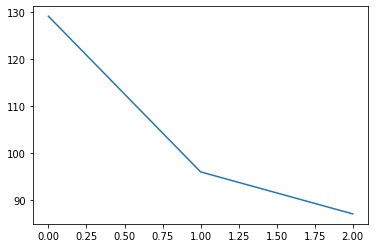

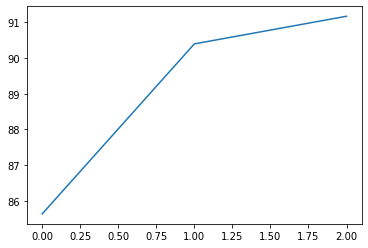

Train confusion matrix: 
[[4480  439]
 [ 685 6396]]
Validation confusion matrix: 
[[570  45]
 [ 98 787]]
Finished Training
Test Loss 6.055459059774876
Test Accuracy 96.93333333333334
Test Confusion Matrix
[[589  26]
 [ 20 865]]


In [94]:
vgg16_task2_2 = models.vgg16(pretrained=True)

'''
  Freeze multiple conv layers
'''
for param in vgg16_task2_2.features[:14].parameters():
    param.requires_grad = False

'''
  Replace FC layers with two FC layers
'''
features= []
features.extend([nn.Linear(25088, 130), nn.ReLU(inplace=True), nn.Dropout()])
features.extend([nn.Linear(130, len(class_names))])
vgg16_task2_2.classifier = nn.Sequential(*features)

output_file='vgg16task2_2.pth'

Epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16_task2_2.parameters(), lr=0.001, momentum=0.9)
train_model(vgg16_task2_2, Epochs, criterion, optimizer, output_file)

loss, accuracy, conf_matrix = compute_loss_and_accuracy(testloader, vgg16_task2_2)
print('Test Loss {}'.format(loss))
print('Test Accuracy {}'.format(accuracy))
print('Test Confusion Matrix')
print(conf_matrix)



Train accuracy: 84.96666666666667 %
Validation accuracy: 89.53333333333333 %



Train accuracy: 89.60000000000001 %
Validation accuracy: 88.93333333333334 %



Train accuracy: 90.54166666666667 %
Validation accuracy: 89.13333333333334 %


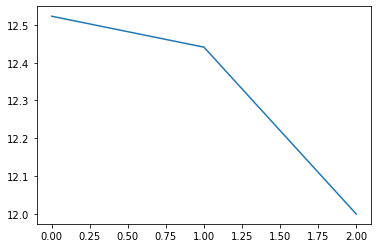

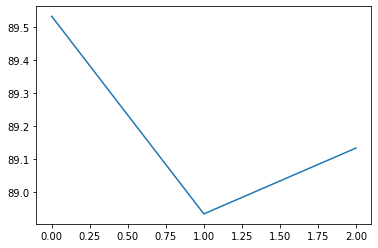

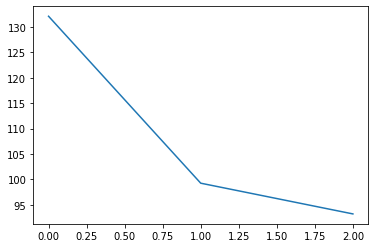

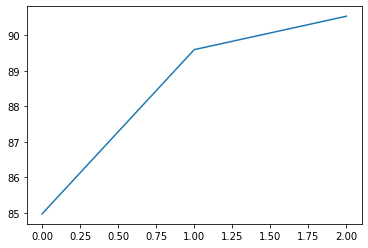

Train confusion matrix: 
[[3877 1042]
 [ 219 6862]]
Validation confusion matrix: 
[[480 135]
 [ 42 843]]
Finished Training
Test Loss 6.9000283144414425
Test Accuracy 94.93333333333334
Test Confusion Matrix
[[546  69]
 [  7 878]]


In [25]:
vgg16_task2_3 = models.vgg16(pretrained=True)

'''
  Do not freeze any conv layers
'''

'''
  Replace FC layers with two FC layers
'''
features= []
features.extend([nn.Linear(25088, 130), nn.ReLU(inplace=True), nn.Dropout()])
features.extend([nn.Linear(130, len(class_names))])
vgg16_task2_3.classifier = nn.Sequential(*features)

output_file='vgg16_entire.pth'

Epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16_task2_3.parameters(), lr=0.001, momentum=0.9)
train_model(vgg16_task2_3, Epochs, criterion, optimizer, output_file)

loss, accuracy, conf_matrix = compute_loss_and_accuracy(testloader, vgg16_task2_3)
print('Test Loss {}'.format(loss))
print('Test Accuracy {}'.format(accuracy))
print('Test Confusion Matrix')
print(conf_matrix)

In [0]:
!cp "/content/vgg16_entire.pth" "./gdrive/My Drive/Colab Notebooks/vgg16_entire.pth"

### RESNET-18


Train accuracy: 76.59166666666667 %
Validation accuracy: 87.93333333333334 %



Train accuracy: 88.69166666666666 %
Validation accuracy: 88.6 %



Train accuracy: 88.84166666666667 %
Validation accuracy: 89.0 %


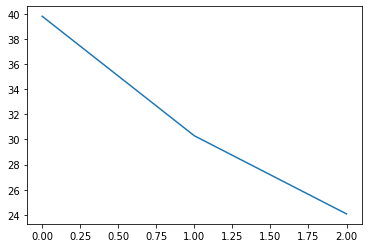

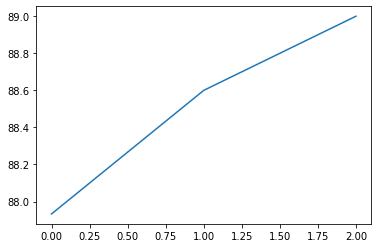

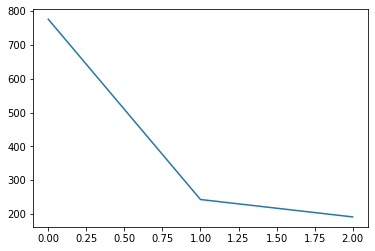

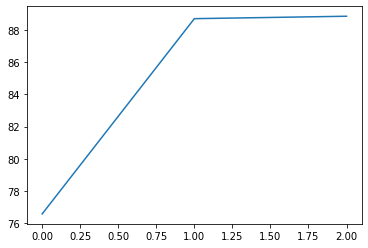

Train confusion matrix: 
[[4186  732    1]
 [ 578 6503    0]
 [   0    0    0]]
Validation confusion matrix: 
[[528  87]
 [ 93 792]]
Finished Training
Test Loss 12.708486337214708
Test Accuracy 94.53333333333333
Test Confusion Matrix
[[559  56]
 [ 26 859]]


In [96]:
resnet18_task2_1 = models.resnet18(pretrained=True)

'''
  Freeze all conv layers except the last convolutional layer
'''
for param in resnet18_task2_1.parameters():
    param.requires_grad = False

for param in resnet18_task2_1.layer4.parameters():
    param.requires_grad = True

'''
  Replace FC layers with two FC layers
'''
features= []
features.extend([nn.Linear(512, 130), nn.ReLU(inplace=True), nn.Dropout()])
features.extend([nn.Linear(130, len(class_names))])
resnet18_task2_1.classifier = nn.Sequential(*features)

output_file='resnet18_task2_1.pth'

Epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18_task2_1.parameters(), lr=0.001, momentum=0.9)
train_model(resnet18_task2_1, Epochs, criterion, optimizer, output_file)

loss, accuracy, conf_matrix = compute_loss_and_accuracy(testloader, resnet18_task2_1)
print('Test Loss {}'.format(loss))
print('Test Accuracy {}'.format(accuracy))
print('Test Confusion Matrix')
print(conf_matrix)


Train accuracy: 79.44166666666666 %
Validation accuracy: 87.33333333333333 %



Train accuracy: 89.06666666666668 %
Validation accuracy: 89.66666666666667 %



Train accuracy: 89.19166666666666 %
Validation accuracy: 88.73333333333333 %


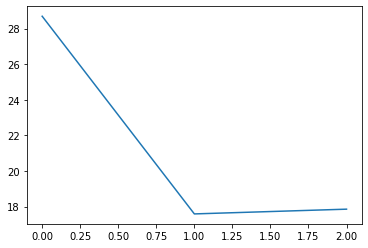

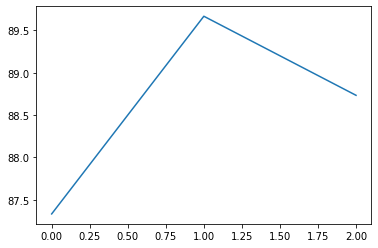

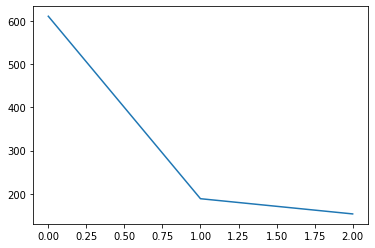

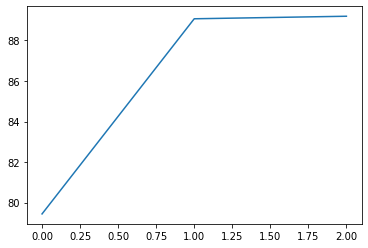

Train confusion matrix: 
[[4226  691    2]
 [ 557 6524    0]
 [   0    0    0]]
Validation confusion matrix: 
[[537  78]
 [ 85 800]]
Finished Training
Test Loss 9.303796797990799
Test Accuracy 95.73333333333333
Test Confusion Matrix
[[571  44]
 [ 20 865]]


In [97]:
resnet18_task2_2 = models.resnet18(pretrained=True)

'''
  Freeze all conv layers except the last and second last convolutional layer
'''
for param in resnet18_task2_2.parameters():
    param.requires_grad = False

for param in resnet18_task2_2.layer3.parameters():
    param.requires_grad = True

for param in resnet18_task2_2.layer4.parameters():
    param.requires_grad = True

'''
  Replace FC layers with two FC layers
'''
features= []
features.extend([nn.Linear(512, 130), nn.ReLU(inplace=True), nn.Dropout()])
features.extend([nn.Linear(130, len(class_names))])
resnet18_task2_2.classifier = nn.Sequential(*features)

output_file='resnet18_task2_2.pth'

Epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18_task2_2.parameters(), lr=0.001, momentum=0.9)
train_model(resnet18_task2_2, Epochs, criterion, optimizer, output_file)

loss, accuracy, conf_matrix = compute_loss_and_accuracy(testloader, resnet18_task2_2)
print('Test Loss {}'.format(loss))
print('Test Accuracy {}'.format(accuracy))
print('Test Confusion Matrix')
print(conf_matrix)


Train accuracy: 84.45 %
Validation accuracy: 86.8 %



Train accuracy: 88.06666666666668 %
Validation accuracy: 87.86666666666666 %



Train accuracy: 89.39166666666667 %
Validation accuracy: 88.73333333333333 %


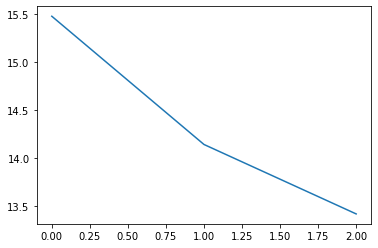

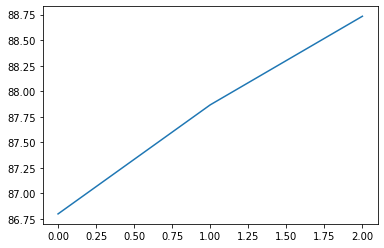

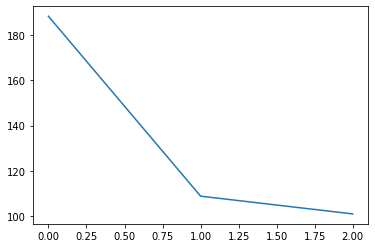

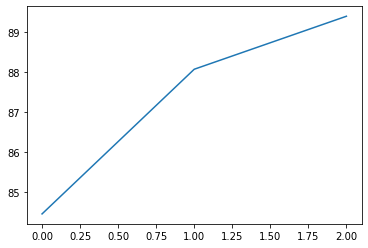

Train confusion matrix: 
[[3809 1110]
 [ 166 6915]]
Validation confusion matrix: 
[[485 130]
 [ 38 847]]
Finished Training
Test Loss 7.260718360543251
Test Accuracy 94.53333333333333
Test Confusion Matrix
[[538  77]
 [  5 880]]


In [11]:
resnet18_task2_3 = models.resnet18(pretrained=True)

'''
  Do not freeze any layer
'''

'''
  Replace FC layers with two FC layers
'''
features= []
features.extend([nn.Linear(512, 130), nn.ReLU(inplace=True), nn.Dropout()])
features.extend([nn.Linear(130, len(class_names))])
resnet18_task2_3.classifier = nn.Sequential(*features)

output_file='res18_entire.pth'

Epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18_task2_3.parameters(), lr=0.001, momentum=0.9)
train_model(resnet18_task2_3, Epochs, criterion, optimizer, output_file)

loss, accuracy, conf_matrix = compute_loss_and_accuracy(testloader, resnet18_task2_3)
print('Test Loss {}'.format(loss))
print('Test Accuracy {}'.format(accuracy))
print('Test Confusion Matrix')
print(conf_matrix)

In [0]:
!cp "/content/res18_entire.pth" "./gdrive/My Drive/Colab Notebooks/res18_entire.pth"

In [54]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected infected normal infected normal normal normal infected
Ground Truth:  infected infected normal infected normal normal normal infected


In [0]:
def show_images(loader, model):
  correct_0 = []
  incorrect_0 = []
  correct_1 = []
  incorrect_1 = []
  with torch.no_grad():
      for data in loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)

          for i in range(len(predicted)):
            if predicted[i] == labels[i]:
              if labels[i] == 0:
                correct_0.append(images[i].cpu())
              else:
                correct_1.append(images[i].cpu())
            else:
              if labels[i] == 0:
                incorrect_0.append(images[i].cpu())
              else:
                incorrect_1.append(images[i].cpu())
            
            if len(correct_0) >=2 and len(incorrect_0)>=2 and len(correct_1)>2 and len(incorrect_1)>=2:
              return correct_0, incorrect_0, correct_1, incorrect_1

  return correct_0, incorrect_0, correct_1, incorrect_1

In [0]:
correct_0, incorrect_0, correct_1, incorrect_1 = show_images(testloader, vgg16)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


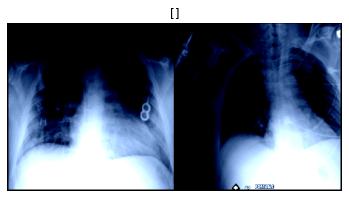

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


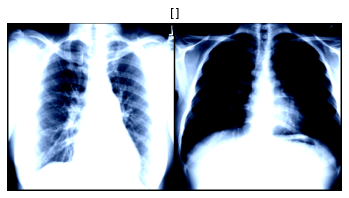

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


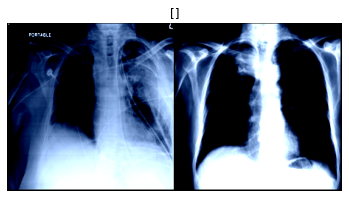

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


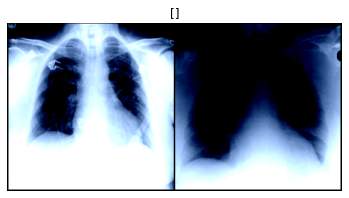

In [39]:
show_databatch(correct_0[2:4], [])
show_databatch(correct_1[:2], [])
show_databatch(incorrect_0[:2], [])
show_databatch(incorrect_1[:2], [])
